In [125]:
import pandas as pd 
import unidecode
import numpy as np 
from datetime import datetime
import math
import json

In [246]:
with open('/Users/weihern/Documents/Sports Analytics/Data/Mappings/fbref_players.json') as f:
    player_map = json.load(f)
with open('/Users/weihern/Documents/Sports Analytics/Data/Mappings/fbref_teams.json') as f:
    team_map = json.load(f)

In [209]:
DATASET  = 'soccer-analytics-344915'

In [ ]:
query = f'''
WITH Touches as (
SELECT
  TeamId,
  MatchId,
  teams.team as team,
  PlayerId,
  players.player as Player,
  X,
  Y,
  Type,
  OutcomeType,
  SatisfiedEventsTypes,
  PassEndX,
  PassEndY,
  Zone,
  Length,
  Angle,
  Period,
  Minute,
  Second,
FROM
  `{DATASET}.Event_Data.EPL_2023` as wc
LEFT JOIN 
  `{DATASET}.Lookup_Tables.Players` as players ON wc.PlayerId = players.id
LEFT JOIN 
  `{DATASET}.Lookup_Tables.Teams` as teams ON wc.TeamId = teams.id
WHERE
isTouch = True)

SELECT * from Touches 
WHERE (
  SELECT count(1)
  FROM UNNEST(SatisfiedEventsTypes) as events
  WHERE events in (5,6,21,22,31,32,33,34,42,44,45,48,50,51,132,133,134,135,136,212)
) <= 0


'''
all_touches_master = pd.read_gbq(query, project_id=DATASET) #openplay
fbref = pd.read_gbq(f'SELECT * FROM `{DATASET}.Stats.Players_2023`', project_id=DATASET, dialect='standard')
fbref['Standard_Squad'] = fbref['Standard_Squad'].replace(team_map)
fbref_epl = fbref[fbref['Standard_Squad'].isin(all_touches_master['team'].unique())]

In [399]:
def create_carries(df):
    def process_df(df):
        df = df.sort_values(['MatchId', 'Period','Minute','Second']).drop(['Events','SatisfiedEventsTypes','Zone'],errors='ignore',axis=1).drop_duplicates().reset_index(drop=True)
        df['TotalTime'] = df['Minute']*60 + df['Second']
        passed_from = [None]
        for i,row in df.iloc[1:].iterrows():
            prev = df.loc[i - 1]
            if (prev['Type'] == 'Pass') & (prev['OutcomeType'] == True) & (prev['MatchId'] == row['MatchId']) & (abs(prev['TotalTime'] - row['TotalTime']) < 10) & (prev['Period'] == row['Period']) & (prev['Player'] != row['Player']) & (prev['TeamId'] == row['TeamId']):
                passed_from.append(prev['Player'])
            else:
                passed_from.append(None)

        passed_to  = []
        for i,row in df[:-1].iterrows():
            if (row['Type'] == 'Pass') & (row['OutcomeType'] == True) & (row['MatchId'] == row['MatchId']) & (abs(row['TotalTime'] - row['TotalTime']) < 10)& (prev['Period'] == row['Period']) & (prev['Player'] != row['Player']) & (prev['TeamId'] == row['TeamId']):
                passed_to.append(df.loc[i+1]['Player'])
            else: 
                passed_to.append(None)
        passed_to.append(None)
        df['PassedFrom'] = passed_from
        df['PassedTo'] = passed_to
        return df
    processed = process_df(df)
    df_passes = processed[(~processed['PassEndX'].isna()) & (processed['OutcomeType'] == True)].copy()
    #xt by carries
    fromx = [None]
    fromy =[None]
    for i,row in processed.iloc[1:].iterrows():
        prev = processed.loc[i - 1]
        if (row['PassedFrom'] != None) & (prev['MatchId'] == row['MatchId']) & (prev['Period'] == row['Period']):
            fromx.append(prev['PassEndX'])
            fromy.append(prev['PassEndY'])
        else:
            fromx.append(None)
            fromy.append(None)
    processed['FromX'] = fromx
    processed['FromY'] = fromy
    return processed
processed = create_carries(all_touches_master)
#carries = processed[processed['FromX'].notna()]

In [404]:
minutes = fbref_epl[['Standard_Player','Standard_Playing_Time_90s']].copy()
minutes['Player']= minutes['Standard_Player'].replace(player_map)

In [405]:
xt_grid = np.array(pd.read_json('https://karun.in/blog/data/open_xt_12x8_v1.json'))
xT_rows, xT_cols = xt_grid.shape
def get_xt(processed):
    def calc_xt(df,x_start,x_end,y_start,y_end,name):
        df['x1_bin'] = pd.cut(df[x_start], bins=xT_cols, labels=False)
        df['y1_bin'] = pd.cut(df[y_start], bins=xT_rows, labels=False)
        df['x2_bin'] = pd.cut(df[x_end], bins=xT_cols, labels=False)
        df['y2_bin'] = pd.cut(df[y_end], bins=xT_rows, labels=False)
        df['start_zone_value'] = df[['x1_bin', 'y1_bin']].apply(lambda x: xt_grid[x[1]][x[0]], axis=1)
        df['end_zone_value'] = df[['x2_bin', 'y2_bin']].apply(lambda x: xt_grid[x[1]][x[0]], axis=1)
        df[name] = df['end_zone_value'] - df['start_zone_value']
        df = df.drop(['x1_bin', 'y1_bin','x2_bin', 'y2_bin','start_zone_value','end_zone_value'],axis=1).drop_duplicates()
        return df[['Player',name]].groupby('Player').sum().sort_values(name,ascending=False).reset_index(drop=False)

    #xt by pass
    df_passes = processed[(processed['Type'] == 'Pass') & (processed['OutcomeType'] == True)].copy()
    xt_passes = calc_xt(df_passes,'X','PassEndX','Y','PassEndY','xT_pass')
    #xt by carries
    processed = processed[processed['FromX'].notna()].copy()
    xt_carries = calc_xt(processed,'FromX','X','FromY','Y','xT_carry')
    xt = pd.merge(xt_passes,xt_carries,on='Player',how='outer')
    xt['xT'] = xt['xT_pass'] + xt['xT_carry']
    xt = xt.sort_values('xT',ascending=False)
    return xt
own_xt = get_xt(processed)
own_xt = own_xt.merge(minutes[['Player','Standard_Playing_Time_90s']],left_on='Player', right_on='Player',how='left')
own_xt = own_xt[own_xt['Standard_Playing_Time_90s'] > 3].copy()
own_xt['xt_rate'] = own_xt['xT']/own_xt['Standard_Playing_Time_90s']
own_xt['xt_rate_pass'] = own_xt['xT_pass']/own_xt['Standard_Playing_Time_90s']
own_xt['xt_rate_carry'] = own_xt['xT_carry']/own_xt['Standard_Playing_Time_90s']

In [406]:
soccerment =  pd.read_csv('/Users/weihern/Documents/Sports Analytics/Data/Soccerment/big5.csv')

In [407]:
own_xt = own_xt.merge(soccerment[['Whoscored_Player','Position']],left_on='Player', right_on='Whoscored_Player',how='left')

In [328]:
positions_lst = own_xt[~own_xt['Position'].isna()]['Position'].unique()[:-1]

In [408]:
own_xt = own_xt.merge(all_touches_master[(all_touches_master['Type'] =='Pass') & (all_touches_master['OutcomeType'] == True)].groupby('Player').size().to_frame('Passes').reset_index(),left_on='Player', right_on='Player',how='left')

In [409]:
own_xt['xt/pass'] = own_xt['xT_pass']/own_xt['Passes']

In [329]:
positions_lst

array(['CAM', 'FB', 'WAM', 'FW', 'CB', 'CM', 'DMC'], dtype=object)

In [418]:
player_lst = ['Kieran Trippier','Fabian Schär','Ethan Pinnock','Pervis Estupiñán','Kevin De Bruyne','James Milner','Kaoru Mitoma','Dejan Kulusevski','Roberto Firmino','Allan Saint-Maximin']

In [580]:
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer import VerticalPitch ,Pitch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from highlight_text import ax_text,fig_text
import matplotlib.lines as lines

In [796]:
BG_COLOR = '#101419'
NOTES_COLOR = '#FFFFF2'
TEXTBOX = 'grey' 
FONT = 'Roboto'
TITLE_FONT = 'Merriweather'
PASS_COLOR = '#44BBA4'
CARRY_COLOR = '#F2545B'


In [600]:
def setup(ax):
    # x_coords = [0.04,0.27,0.53,0.76,0.28,0.52,0.15,0.4,0.65,0.4]
    # y_coords = [0.13,0.05,0.05,0.13,0.29,0.29,0.54,0.54,0.54,0.765]
    # x_text = [11,36,64,89,37,63.5,22.5,50,76.5,50]
    # y_text = [9,1,1,9,26.5,26.5,53,53,53,76.5]
        
    x_coords = [0.04,0.27,0.53,0.76,0.15,0.4,0.65,0.15,0.4,0.65]
    y_coords = [0.15,0.1,0.1,0.15,0.42,0.34,0.42,0.7,0.75,0.7]
    x_text = [10,36,64,89,22.5,50,76.5,22.5,50,76.5]
    y_text = [11,6,6,11,39.5,31.5,39.5,69,74,69]
    pitch = VerticalPitch(pitch_type='opta',pitch_color = BG_COLOR,line_color='white',linewidth = 0.6, line_alpha=0.4)
    smallPitch = VerticalPitch(pitch_type='opta',pitch_color=BG_COLOR, line_color='white',line_zorder=3,linewidth = 0.6, line_alpha=0.4)
    pitch.draw(ax= ax)
    axs = []
    for x,y,player in zip(x_coords,y_coords,player_lst):
        new = ax.inset_axes([0.8-x,y,0.2,0.2])
        smallPitch.draw(ax=new)
        axs.append(new)
    for x,y,player in zip(x_text,y_text,player_lst):
        val = own_xt[own_xt['Player'] == player]['xt_rate'].values[0]
        ax.text(x,y+1.1,player + ' (' + str(round(val,2)) + ')',va='top',fontsize=7.5,ha='center',color = NOTES_COLOR,font=FONT,fontweight='demi')

    subs = ax.inset_axes([0.035,-0.21,0.93,0.2])
    return axs,subs

In [440]:
def autoElbow(df):
    distortions = []
    K = range(1,4)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(df)
        distortions.append(kmeanModel.inertia_)
    differences = [j-i for i, j in zip(distortions[:-1], distortions[1:])]
    elbow = differences.index(max(differences)) + 1
    return elbow

In [670]:
def draw_one(ax,player):
    def plot_arrows(X,ax,startx,starty,endx,endy,color,type):
        elbow = 2 if type =='Carry' else 3
        kmeans = KMeans(n_clusters=elbow)
        kmeans.fit(X)
        X['cluster'] = kmeans.labels_
        pitch = VerticalPitch(pitch_type='opta',pitch_color=BG_COLOR, line_color='white',line_zorder=3,linewidth = 0.6, line_alpha=0.4)
        clusters = X.groupby(X['cluster']).mean().reset_index(names ='cluster')
        top2= X.groupby(X['cluster']).size().reset_index().sort_values(by=0,ascending=False)
        pitch.lines(X[startx],X[starty],X[endx],X[endy],ax=ax,lw=0.7,color='grey',alpha =0.07)
        pitch.scatter(X[endx],X[endy],ax=ax,color='grey',alpha =0.07,s=10,linewidths=0)
        for cluster in top2['cluster']:
            if type == 'Carry':
                pitch.arrows(clusters[clusters['cluster'] == cluster][startx],clusters[clusters['cluster'] == cluster][starty],clusters[clusters['cluster'] == cluster][endx],clusters[clusters['cluster'] == cluster][endy],
                   ax=ax,headwidth=6, headlength=4, headaxislength=3,width=1,color=color,alpha=1)
            else:
                pitch.lines(clusters[clusters['cluster'] == cluster][startx],clusters[clusters['cluster'] == cluster][starty],clusters[clusters['cluster'] == cluster][endx],clusters[clusters['cluster'] == cluster][endy],
                    ax=ax,linewidth=1.5,color=color,alpha=1)
                pitch.scatter(clusters[clusters['cluster'] == cluster][endx],clusters[clusters['cluster'] == cluster][endy],
                ax=ax,color=color,alpha=1,s=15,linewidths=0)
    player_df = processed[processed['Player'] == player].copy()
    passess = player_df[player_df['Type'] == 'Pass'].copy()
    passess = passess[passess['Length'] > 6.25].copy()
    carries = player_df[player_df['FromX'].notna()].copy()
    carries['Dist'] = np.sqrt((carries['X']-carries['FromX'])**2 + (carries['Y']-carries['FromY'])**2)
    carries = carries[carries['Dist'] > 6.25].copy()
    plot_arrows(passess[['X','Y','PassEndX','PassEndY']].copy(),ax,'X','Y','PassEndX','PassEndY',PASS_COLOR,'Pass')
    plot_arrows(carries[['FromX','FromY','X','Y']].copy(),ax,'FromX','FromY','X','Y',CARRY_COLOR,'Carry')
    return ax
# fig,ax = plt.subplots(figsize=(10,10))
# pitch = VerticalPitch(pitch_type='opta',pitch_color=BG_COLOR, line_color='white',line_zorder=3,linewidth = 0.6, line_alpha=0.4)
# pitch.draw(ax = ax)
# _ = draw_one(ax = ax,player = 'Kieran Trippier')

In [614]:
def subs(ax):
    ax.text(1,112,'Honorable Mentions:',fontsize = 8,va='top',ha='left',color = NOTES_COLOR,font=FONT,alpha=0.6)
    ax.set_facecolor(BG_COLOR)
    ax.set_xlim(0,100)
    y_adjust = 12
    y_interval = 10
    ax.vlines([33,66],18,100,colors='white',alpha=0.4,linewidth=0.6)
    ax.text(2,100,'Defenders',fontsize = 9,va='top',ha='left',color = NOTES_COLOR,font=FONT,fontweight='demi')
    defenders = own_xt[own_xt['Position'].isin(['FB','CB'])].sort_values(by='xt_rate',ascending=False).head(15)['Player'].values
    defenders = [x for x in defenders if x not in player_lst][:7]
    for player in defenders:
        val = own_xt[own_xt['Player'] == player]['xt_rate'].values[0]
        ax.text(2,100 - y_interval * defenders.index(player) - y_adjust,player + ' (' + str(round(val,2)) + ')',va='top',fontsize=7.5,ha='left',color = NOTES_COLOR,font=FONT)
    ax.text(35,100,'Midfielders',fontsize = 9,va='top',ha='left',color = NOTES_COLOR,font=FONT,fontweight='demi')
    midfielders = own_xt[own_xt['Position'].isin(['CM','DMC','CAM'])].sort_values(by='xt_rate',ascending=False).head(15)['Player'].values
    midfielders= [x for x in midfielders if x not in player_lst][:7]
    for player in midfielders:
        val = own_xt[own_xt['Player'] == player]['xt_rate'].values[0]
        ax.text(35,100 - y_interval * midfielders.index(player)-y_adjust,player + ' (' + str(round(val,2)) + ')',va='top',fontsize=7.5,ha='left',color = NOTES_COLOR,font=FONT)
    ax.text(68,100,'Attackers',fontsize = 9,va='top',ha='left',color = NOTES_COLOR,font=FONT,fontweight='demi')
    attackers = own_xt[own_xt['Position'].isin(['FW','WAM'])].sort_values(by='xt_rate',ascending=False).head(15)['Player'].values
    attackers = [x for x in attackers if x not in player_lst][:7]
    for player in attackers:
        val = own_xt[own_xt['Player'] == player]['xt_rate'].values[0]
        ax.text(68,100 - y_interval * attackers.index(player)-y_adjust,player + ' (' + str(round(val,2)) + ')',va='top',fontsize=7.5,ha='left',color = NOTES_COLOR,font=FONT)
    ax.axis('off')
    return ax

Text(0.5, 0.935, ' ')

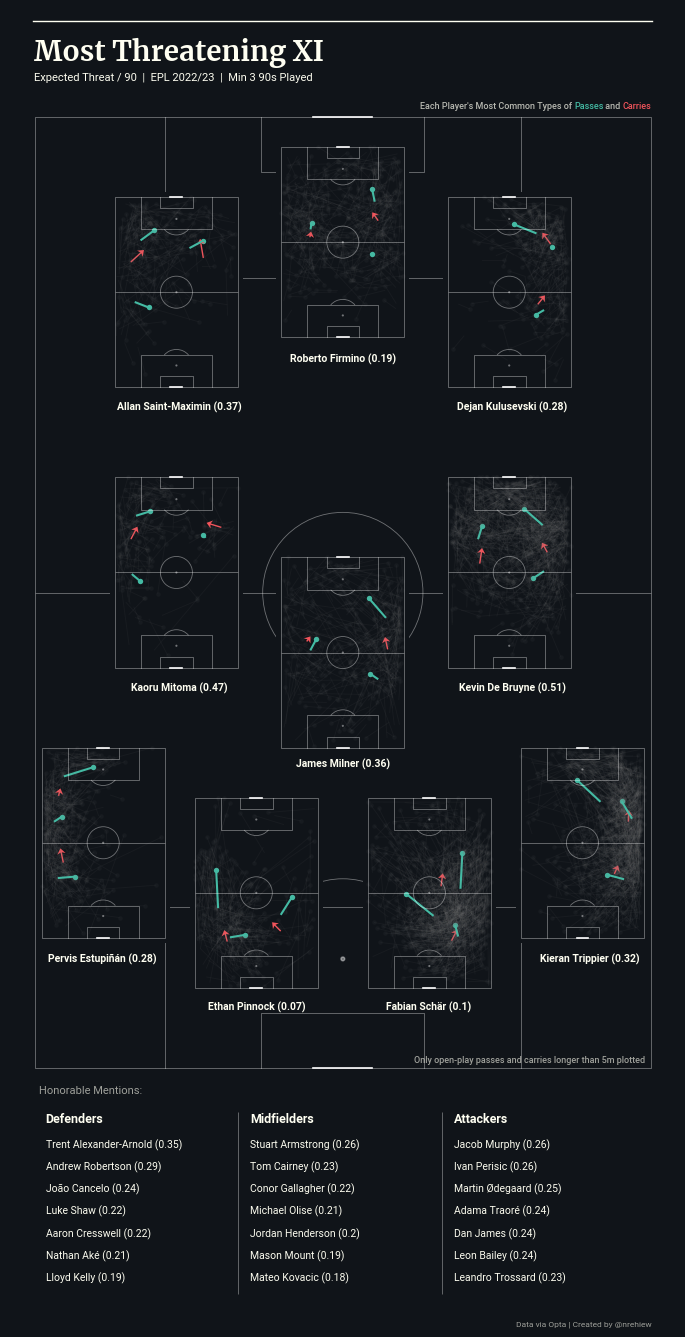

In [797]:
fig,ax = plt.subplots(figsize=(13,13))
fig.set_facecolor(BG_COLOR)
axs,sub_ax = setup(ax)
for ax,player in zip(axs,player_lst):
    draw_one(ax,player)
ax_text(-0.1,100.6, '''Each Player's Most Common Types of <Passes> and <Carries>''',ha='right',va='bottom', alpha = 0.7,
font=FONT,color = NOTES_COLOR,fontsize = 6.5,fontweight ='roman',highlight_textprops=[{'color':PASS_COLOR,'alpha':1},{'color':CARRY_COLOR,'alpha':1}])
fig.text(0.745,0.132, '''Only open-play passes and carries longer than 5m plotted''',ha='right',va='bottom', alpha = 0.6,
font=FONT,color = NOTES_COLOR,fontsize = 6.5,fontweight ='roman')
sub_ax = subs(sub_ax) 

fig.text(0.75,-0.07,'Data via Opta | Created by @nrehiew',fontsize=6,va='bottom',ha='right',color = NOTES_COLOR,font=FONT,alpha=0.6)

fig.text(0.275,0.922,'Most Threatening XI',fontsize=20,va='top',ha='left',color = NOTES_COLOR,font=TITLE_FONT,fontweight='heavy')
fig.text(0.275,0.895,'Expected Threat / 90  |  EPL 2022/23  |  Min 3 90s Played',fontsize=8,va='top',ha='left',color = NOTES_COLOR,font=FONT)

_ = fig.add_artist(lines.Line2D([0.274,0.75],[0.935],linewidth=1,color=NOTES_COLOR))
fig.text(0.5,0.935,' ')

In [758]:
from adjustText import adjust_text
from matplotlib.patches import Rectangle

Text(0.9, 0.12, 'Data via Opta | Created by @nrehiew')

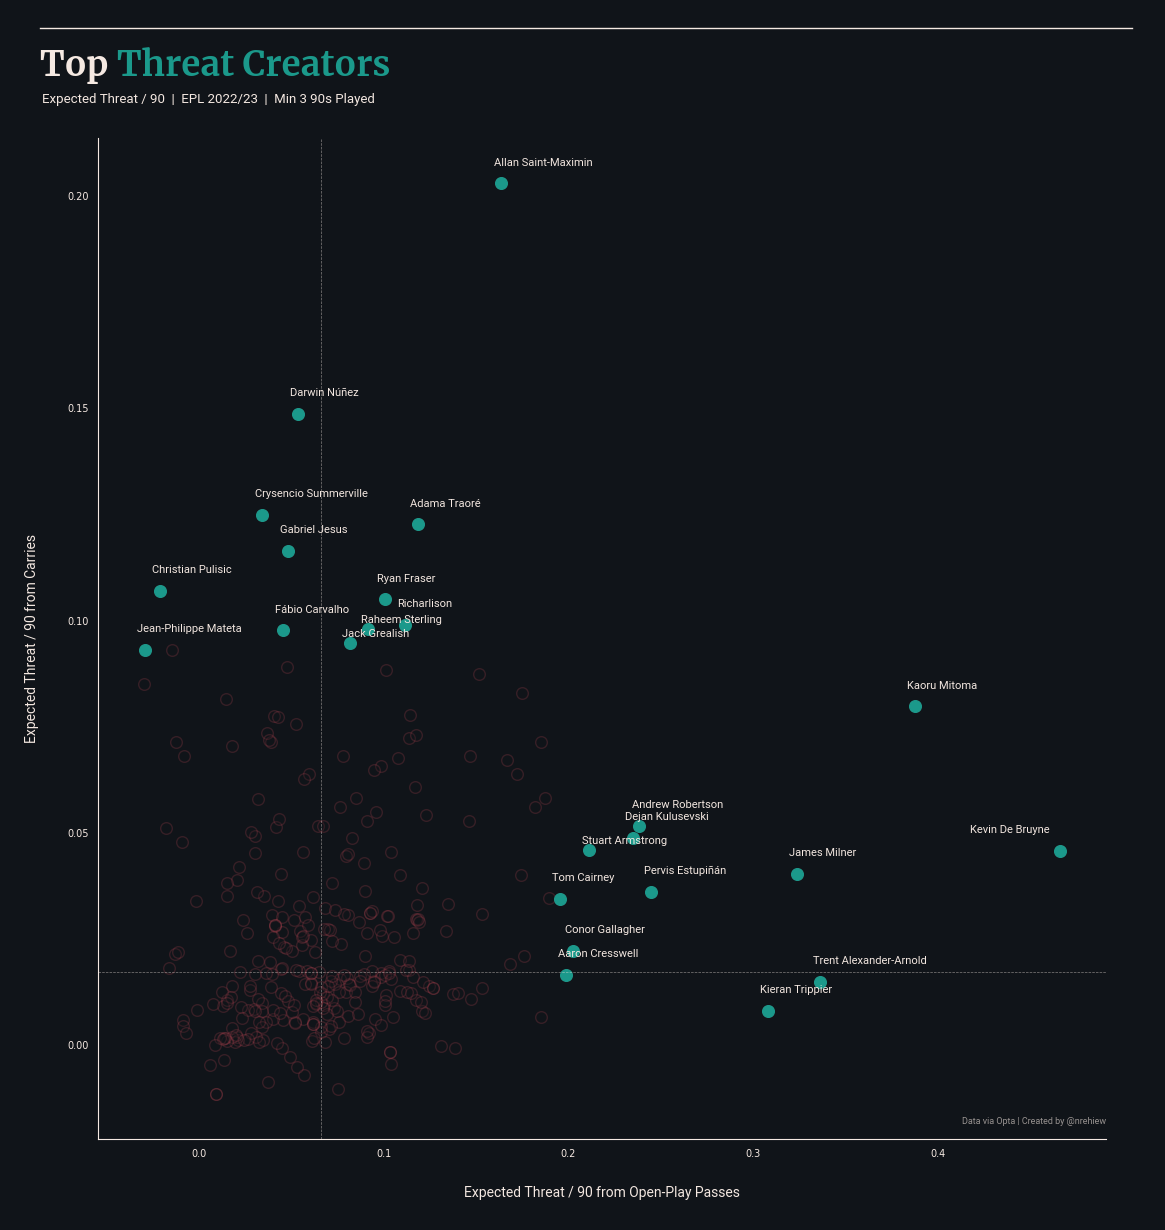

In [793]:
POINT_COLOR ='#1B998B'
OTHER_COLOR = '#D44D5C'
NOTES_COLOR = '#F5E9E2'

fig,ax = plt.subplots(figsize=(13,13))
ax.scatter(own_xt['xt_rate_pass'],own_xt['xt_rate_carry'],color =BG_COLOR,edgecolor = OTHER_COLOR,s=70,alpha=0.2)
texts = []
to_label = list(set(own_xt.sort_values(by='xt_rate_pass',ascending=False).head(12)['Player'].values.tolist() 
    + own_xt.sort_values(by='xt_rate_carry',ascending=False).head(12)['Player'].values.tolist()))
for player in to_label:
    text = ax.text(own_xt[own_xt['Player'] == player]['xt_rate_pass'].values[0]-0.005,own_xt[own_xt['Player'] == player]['xt_rate_carry'].values[0]+0.0035,player
    ,va='center',ha='center',color = NOTES_COLOR,font=FONT,fontsize=8,wrap=True)
    # text._get_wrap_line_width = lambda : 60
    texts.append(text)
to_label_plot = own_xt[own_xt['Player'].isin(to_label)]
ax.scatter(to_label_plot['xt_rate_pass'],to_label_plot['xt_rate_carry'],color =POINT_COLOR,edgecolor = None,s=70)
adjust_text(texts,ha='center')
for direction in ['right','top']:
    ax.spines[direction].set_visible(False)
plt.xlabel('Expected Threat / 90 from Open-Play Passes',color = NOTES_COLOR,font=FONT,labelpad=20,zorder =3)
plt.ylabel('Expected Threat / 90 from Carries',color = NOTES_COLOR,font=FONT,labelpad=20,zorder =3)
plt.tick_params(axis='both',which='both',bottom=False,top=False,left=False,labelbottom=True) 
fig.set_facecolor(BG_COLOR)
ax.set_facecolor(BG_COLOR)
ax.spines['left'].set_color(NOTES_COLOR)
ax.spines['bottom'].set_color(NOTES_COLOR)
ax.tick_params(axis='both', colors=NOTES_COLOR,which='both', labelsize = 7)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot([own_xt['xt_rate_pass'].median(),own_xt['xt_rate_pass'].median()],ylim,color = NOTES_COLOR,linewidth=0.5,alpha=0.5,linestyle = '--')
ax.plot(xlim,[own_xt['xt_rate_carry'].median(),own_xt['xt_rate_carry'].median()],color = NOTES_COLOR,linewidth=0.5,alpha=0.5,linestyle = '--')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

_ = fig.add_artist(lines.Line2D([0.08,0.92],[0.965],linewidth=1,color=NOTES_COLOR))
fig_text(0.08,0.95,'Top <Threat Creators>',ha='left',va='top', alpha = 1,fontsize=25,highlight_textprops=[{'color':POINT_COLOR}],color=NOTES_COLOR,font=TITLE_FONT,fontweight='heavy')
fig.text(0.082,0.915,'Expected Threat / 90  |  EPL 2022/23  |  Min 3 90s Played',fontsize=9.5,va='top',ha='left',color = NOTES_COLOR,font=FONT)
fig.text(0.935,0.97,' ')
fig.text(0.057,0.05,' ')
fig.text(0.9,0.12,'Data via Opta | Created by @nrehiew',fontsize=6.5,va='bottom',ha='right',color = NOTES_COLOR,font=FONT,alpha=0.6)

